In [1]:
#%pip install kaggle-cli
#%pip install -U pycaret
#%pip install missingno -U
#%pip install lazypredict -U
#from lazypredict.Supervised import LazyClassifier
#%pip uninstall scipy -y
#%pip install scipy==1.9.3


In [2]:
#%pip install kaggle-cli
#import kaggle

# Shell command syntax for Jupyter
#!kaggle competitions download -c playground-series-s5e12

In [3]:
# =====================================================================
# Imports
# =====================================================================
import os
import pandas as pd

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

import numpy as np

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from pycaret.classification import *
import shap

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier




from datetime import datetime
import time
import warnings
import multiprocessing

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")


# =============================================================================
# MULTIPROCESSING SETUP
# =============================================================================
CPU_COUNT = multiprocessing.cpu_count()
N_JOBS = max(1, CPU_COUNT - 1)

os.environ["OMP_NUM_THREADS"] = str(N_JOBS)
os.environ["MKL_NUM_THREADS"] = str(N_JOBS)
os.environ["OPENBLAS_NUM_THREADS"] = str(N_JOBS)

# =============================================================================
# SETUP
# =============================================================================
print("=" * 80)
print("DIABETES PREDICTION MODEL COMPARISON (BALANCED + MULTIPROCESSING)")
print(f"CPUs available: {CPU_COUNT}")
print(f"CPUs used: {N_JOBS}")
print("=" * 80)

DIABETES PREDICTION MODEL COMPARISON (BALANCED + MULTIPROCESSING)
CPUs available: 8
CPUs used: 7


In [4]:
# Add at the top with other configurations
if __name__ == '__main__':
    multiprocessing.freeze_support()

In [5]:
data_folder= "playground-series-s5e12"

In [6]:

# Get number of cores for parallel processing
#n_jobs = multiprocessing.cpu_count() - 1

!dir playground-series-s5e12
!ls playground-series-s5e12

 Volume in drive C has no label.
 Volume Serial Number is 8465-2C23

 Directory of c:\Users\DELL\Desktop\DataScience\Kaggle\DiabetesPredictionChallenge\playground-series-s5e12

08/12/2025  15:22    <DIR>          .
29/12/2025  18:13    <DIR>          ..
29/10/2025  17:10         2,700,022 sample_submission.csv
29/10/2025  17:10        34,565,636 test.csv
29/10/2025  17:10        83,302,401 train.csv
               3 File(s)    120,568,059 bytes
               2 Dir(s)  201,598,763,008 bytes free


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
test = pd.read_csv(os.path.join(data_folder, "test.csv"))
train = pd.read_csv(os.path.join(data_folder, "train.csv"))
test.shape, train.shape

((300000, 25), (700000, 26))

In [8]:
train.columns

Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'education_level',
       'income_level', 'smoking_status', 'employment_status',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [10]:
train.describe()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,349999.500000,50.359734,2.072411,80.230803,5.963695,7.002200,6.012733,25.874684,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324,0.623296
std,202072.738554,11.655520,1.048189,51.195071,1.463336,0.901907,2.022707,2.860705,0.037980,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478,0.484560
min,0.000000,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000,0.000000
25%,174999.750000,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,349999.500000,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000,1.000000
75%,524999.250000,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.800000,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000,1.000000
max,699999.000000,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400000,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train.id.duplicated().sum()

0

In [12]:
train.select_dtypes(include=['number']).drop(columns=['id']).columns

Index(['age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')

In [13]:
train.select_dtypes(include=['object']).columns

Index(['gender', 'ethnicity', 'education_level', 'income_level',
       'smoking_status', 'employment_status'],
      dtype='object')

In [14]:
train.select_dtypes(include=['object']).head()

,gender,ethnicity,education_level,income_level,smoking_status,employment_status
0,Female,Hispanic,Highschool,Lower-Middle,Current,Employed
1,Female,White,Highschool,Upper-Middle,Never,Employed
2,Male,Hispanic,Highschool,Lower-Middle,Never,Retired
3,Female,White,Highschool,Lower-Middle,Current,Employed
4,Male,White,Highschool,Upper-Middle,Never,Retired


In [15]:
train.select_dtypes(include=['number']).head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,0,1,0,1.0


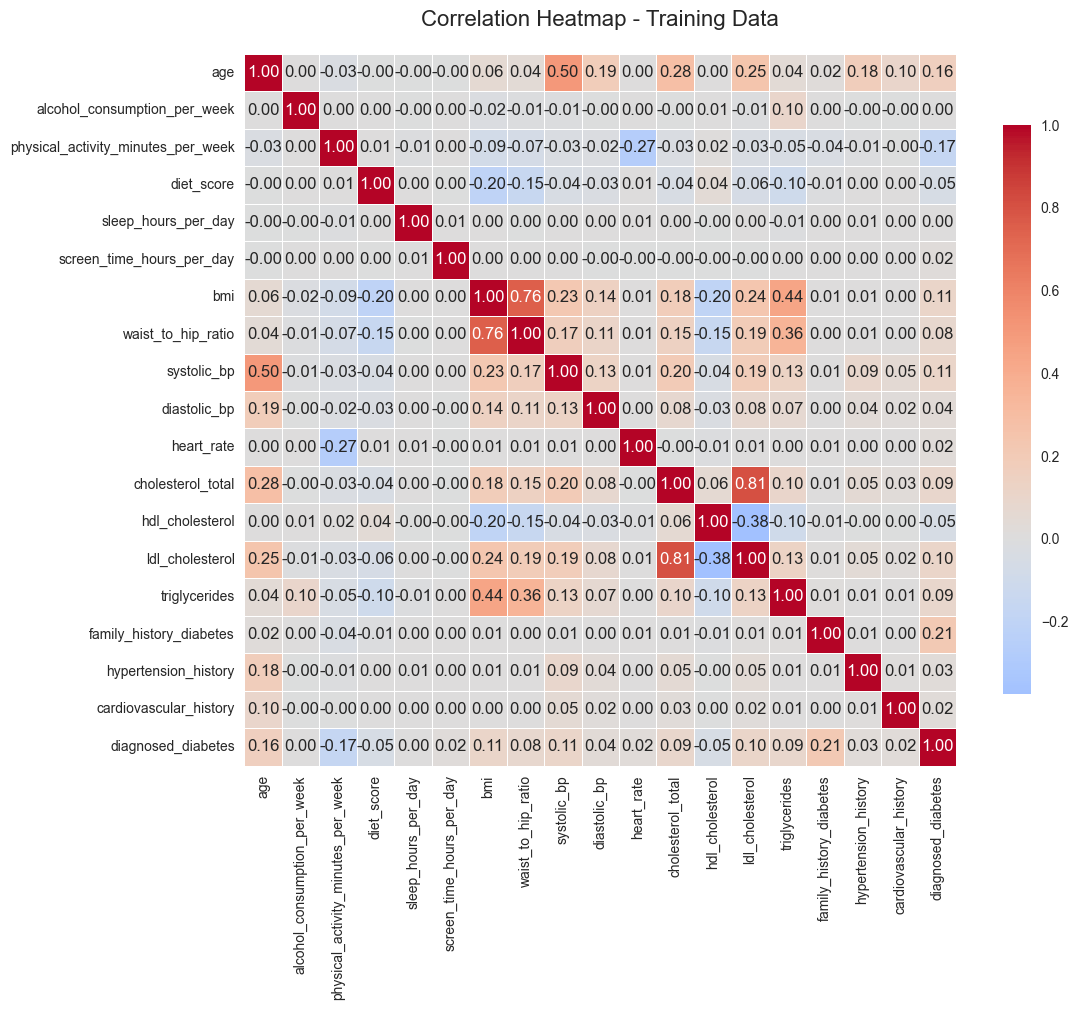

In [16]:
# Calculate correlation matrix (only for numeric columns)
correlation_matrix = train.select_dtypes(include=['number']).drop(columns=['id']).corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            fmt='.2f',   # Format to 2 decimal places
            cmap='coolwarm',  # Color scheme
            center=0,    # Center colormap at 0
            square=True, # Make cells square
            linewidths=0.5,
            cbar_kws={'shrink': 0.8})

plt.title('Correlation Heatmap - Training Data', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Optional: Show top correlations with target variable (if you have one)
if 'target' in train.columns or 'price' in train.columns:
    target_col = 'target' if 'target' in train.columns else 'price'
    correlations = train.corr()[target_col].sort_values(ascending=False)
    print(f"\nTop correlations with {target_col}:")
    print(correlations)

<Figure size 1200x600 with 0 Axes>

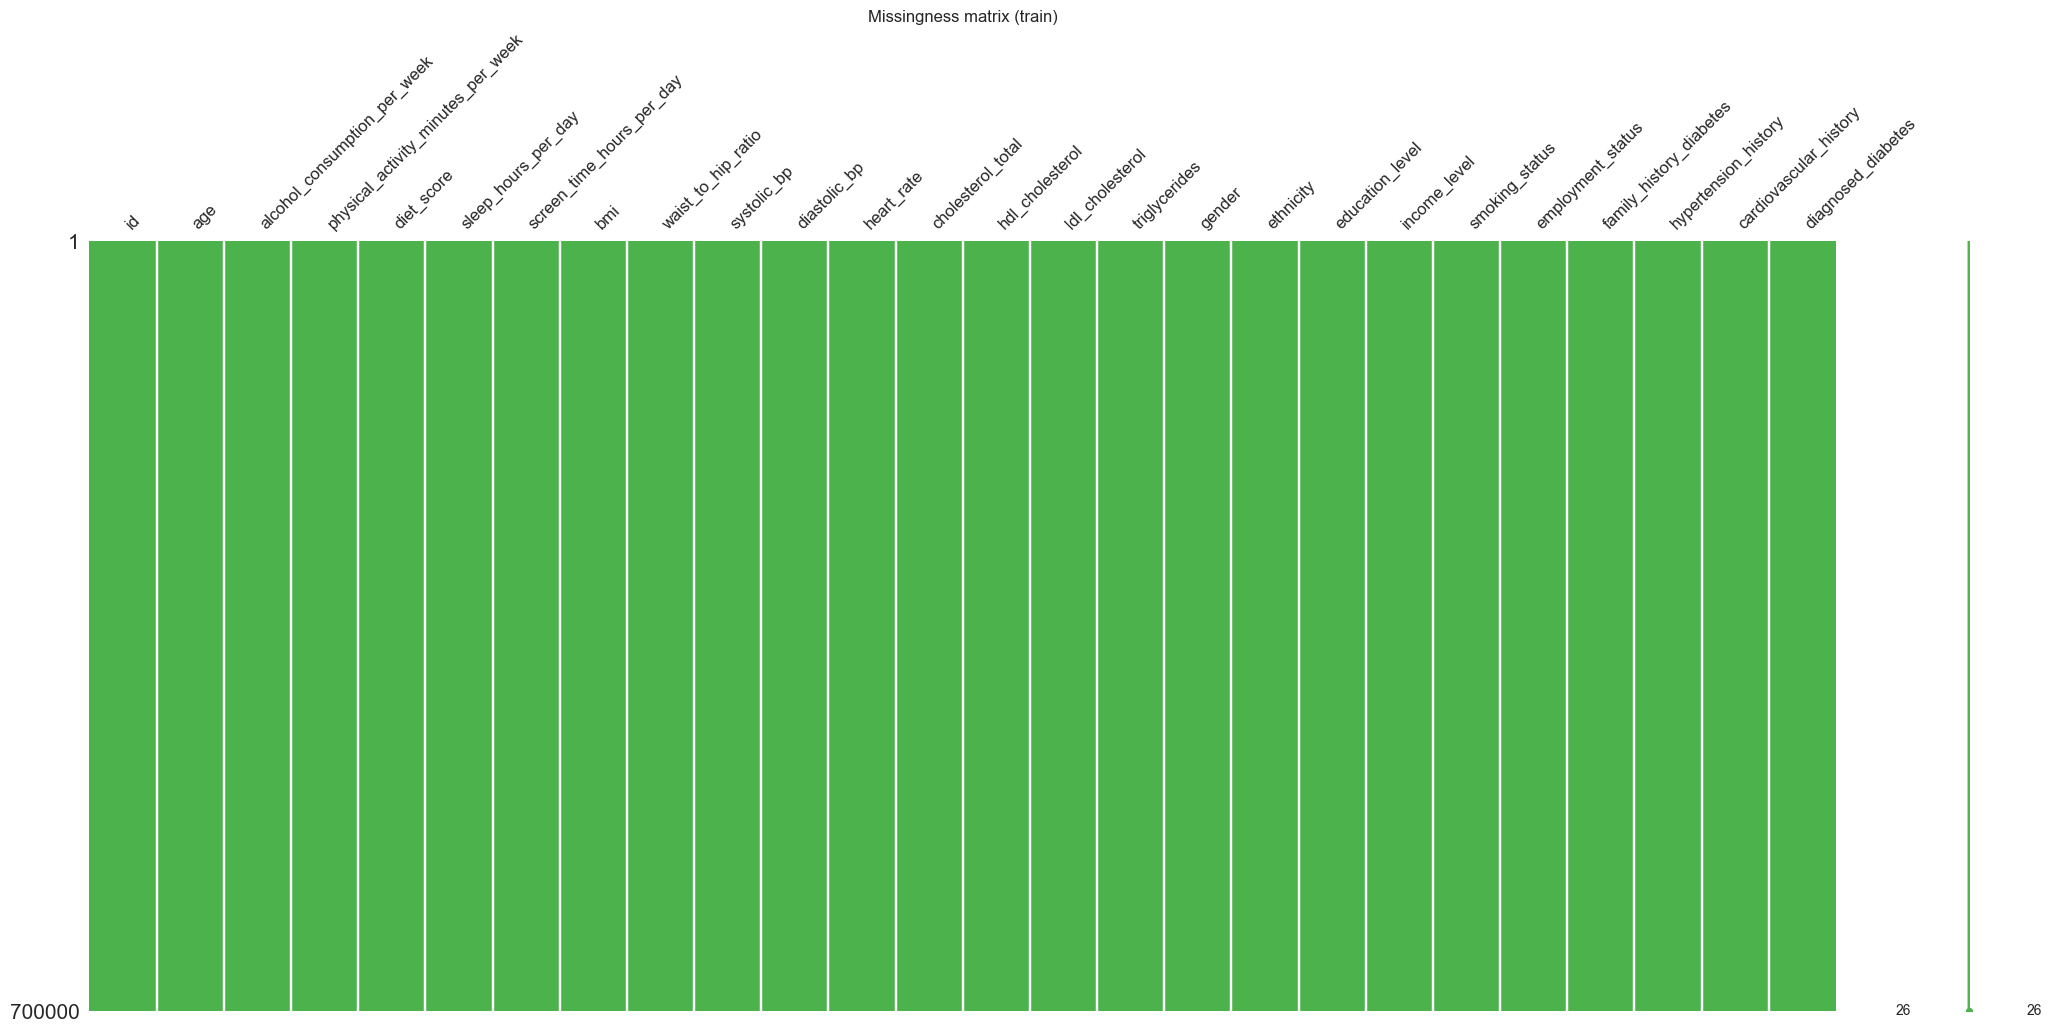

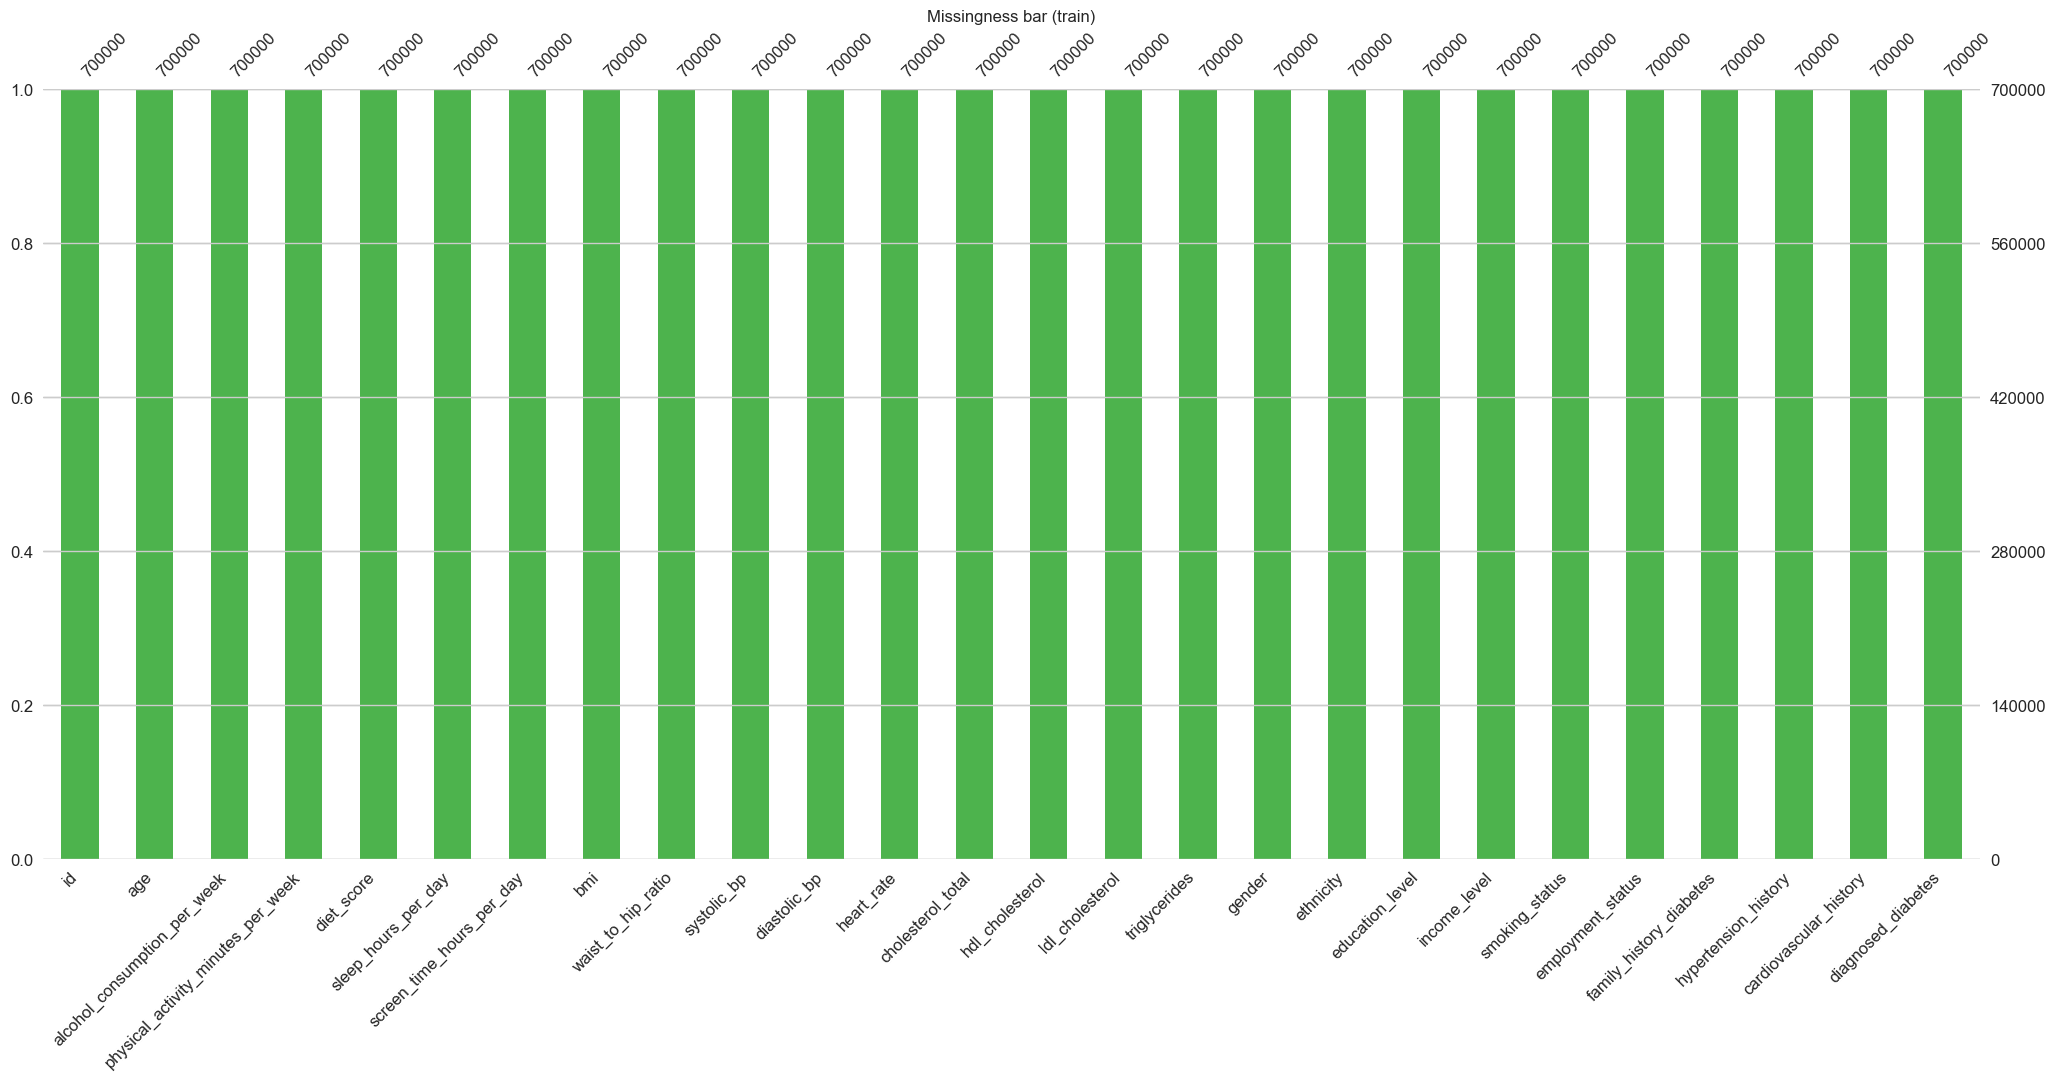

In [17]:
# missingno matrix: shows a visual sparsity grid (white = missing)
plt.figure(figsize=(12, 6))
msno.matrix(train, fontsize=12, color=(0.3, 0.7, 0.3))
plt.title("Missingness matrix (train)")
plt.show()

# missingno bar: shows percent present/missing per column
plt.figure(figsize=(10, 6))
msno.bar(train, fontsize=12, color=(0.3, 0.7, 0.3))
plt.title("Missingness bar (train)")
plt.show()

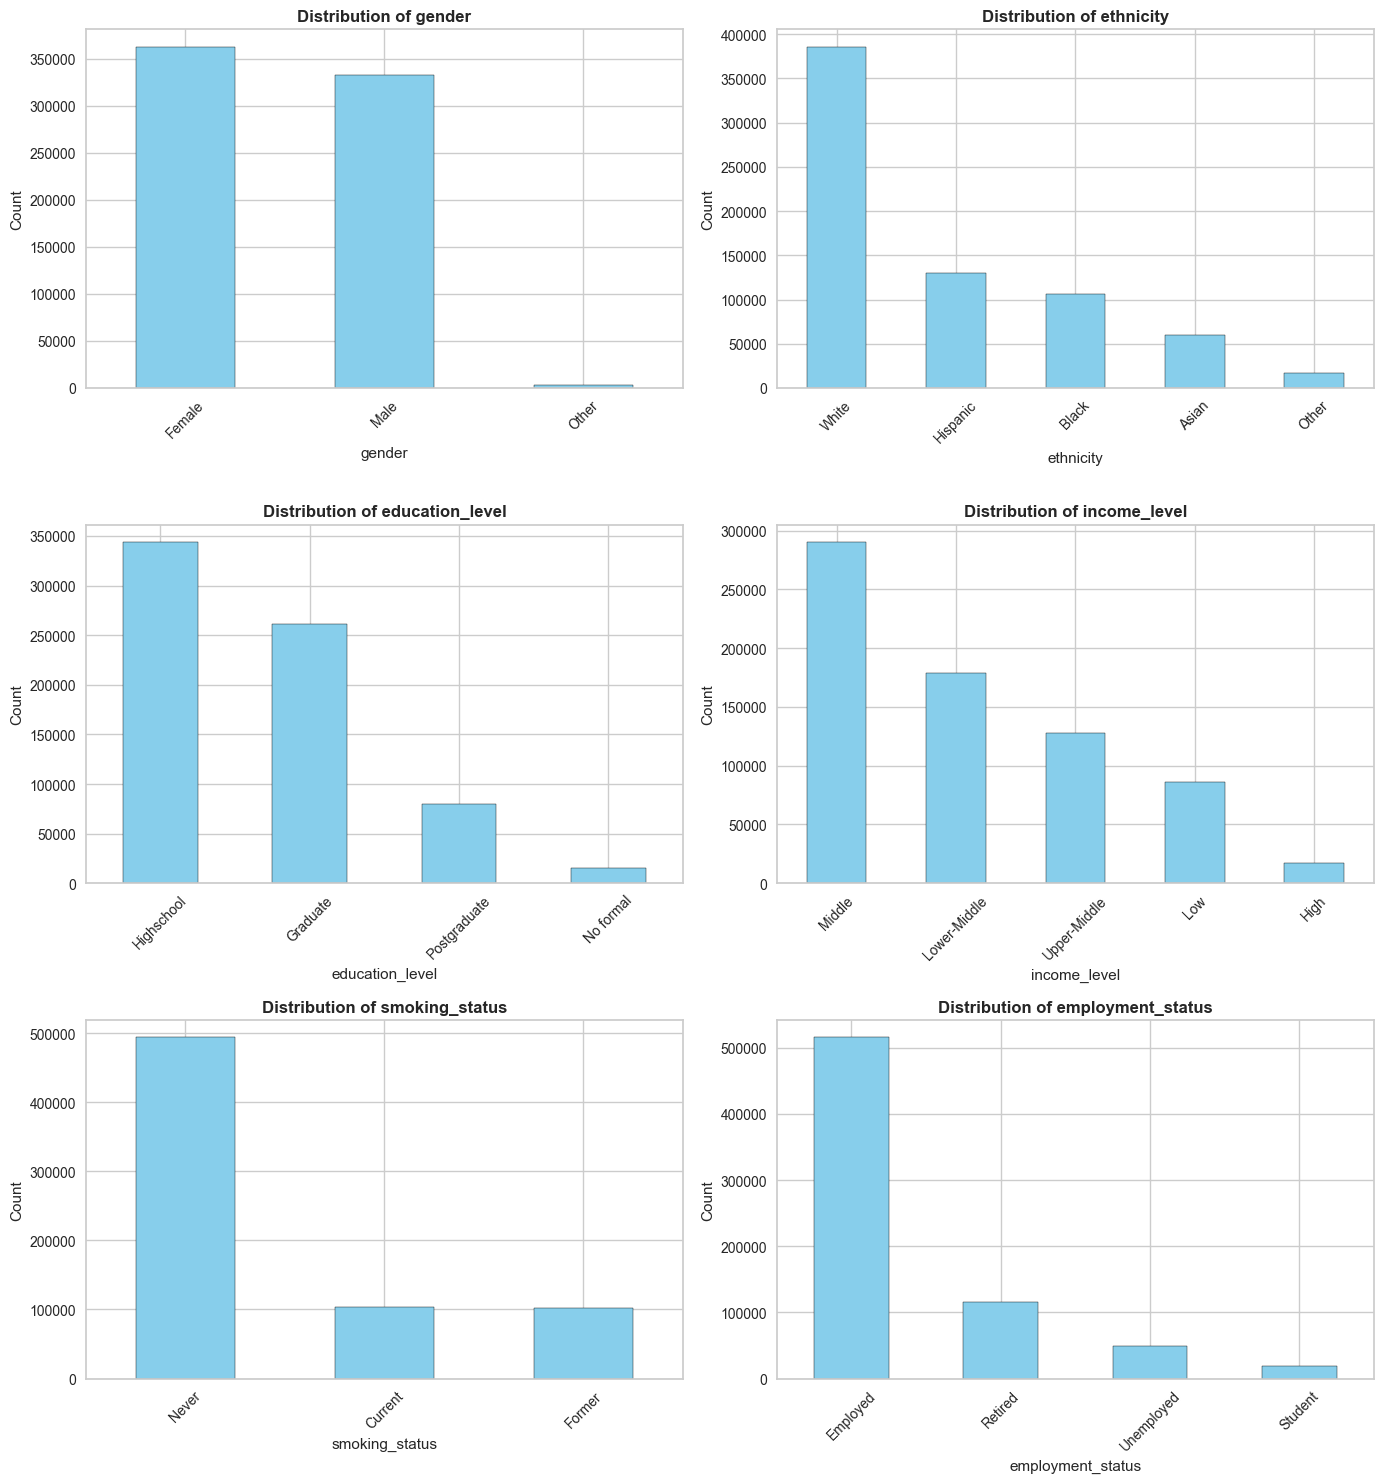


gender unique values (3 unique):
gender
Female    363237
Male      333085
Other       3678
Name: count, dtype: int64

ethnicity unique values (5 unique):
ethnicity
White       386153
Hispanic    129984
Black       106301
Asian        60120
Other        17442
Name: count, dtype: int64

education_level unique values (4 unique):
education_level
Highschool      344145
Graduate        261268
Postgraduate     79642
No formal        14945
Name: count, dtype: int64

income_level unique values (5 unique):
income_level
Middle          290557
Lower-Middle    178570
Upper-Middle    127836
Low              85803
High             17234
Name: count, dtype: int64

smoking_status unique values (3 unique):
smoking_status
Never      494448
Current    103363
Former     102189
Name: count, dtype: int64

employment_status unique values (4 unique):
employment_status
Employed      516170
Retired       115735
Unemployed     49787
Student        18308
Name: count, dtype: int64


In [18]:
# Get categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns
n_cat_cols = len(categorical_cols)
n_rows = (n_cat_cols + 1) // 2  # 2 columns per row

fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    # Get value counts and plot
    value_counts = train[col].value_counts()
    value_counts.plot(kind='bar', ax=axes[idx], color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Hide extra subplots if any
for idx in range(n_cat_cols, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Also print unique values for reference
for col in categorical_cols:
    print(f"\n{col} unique values ({train[col].nunique()} unique):")
    print(train[col].value_counts())

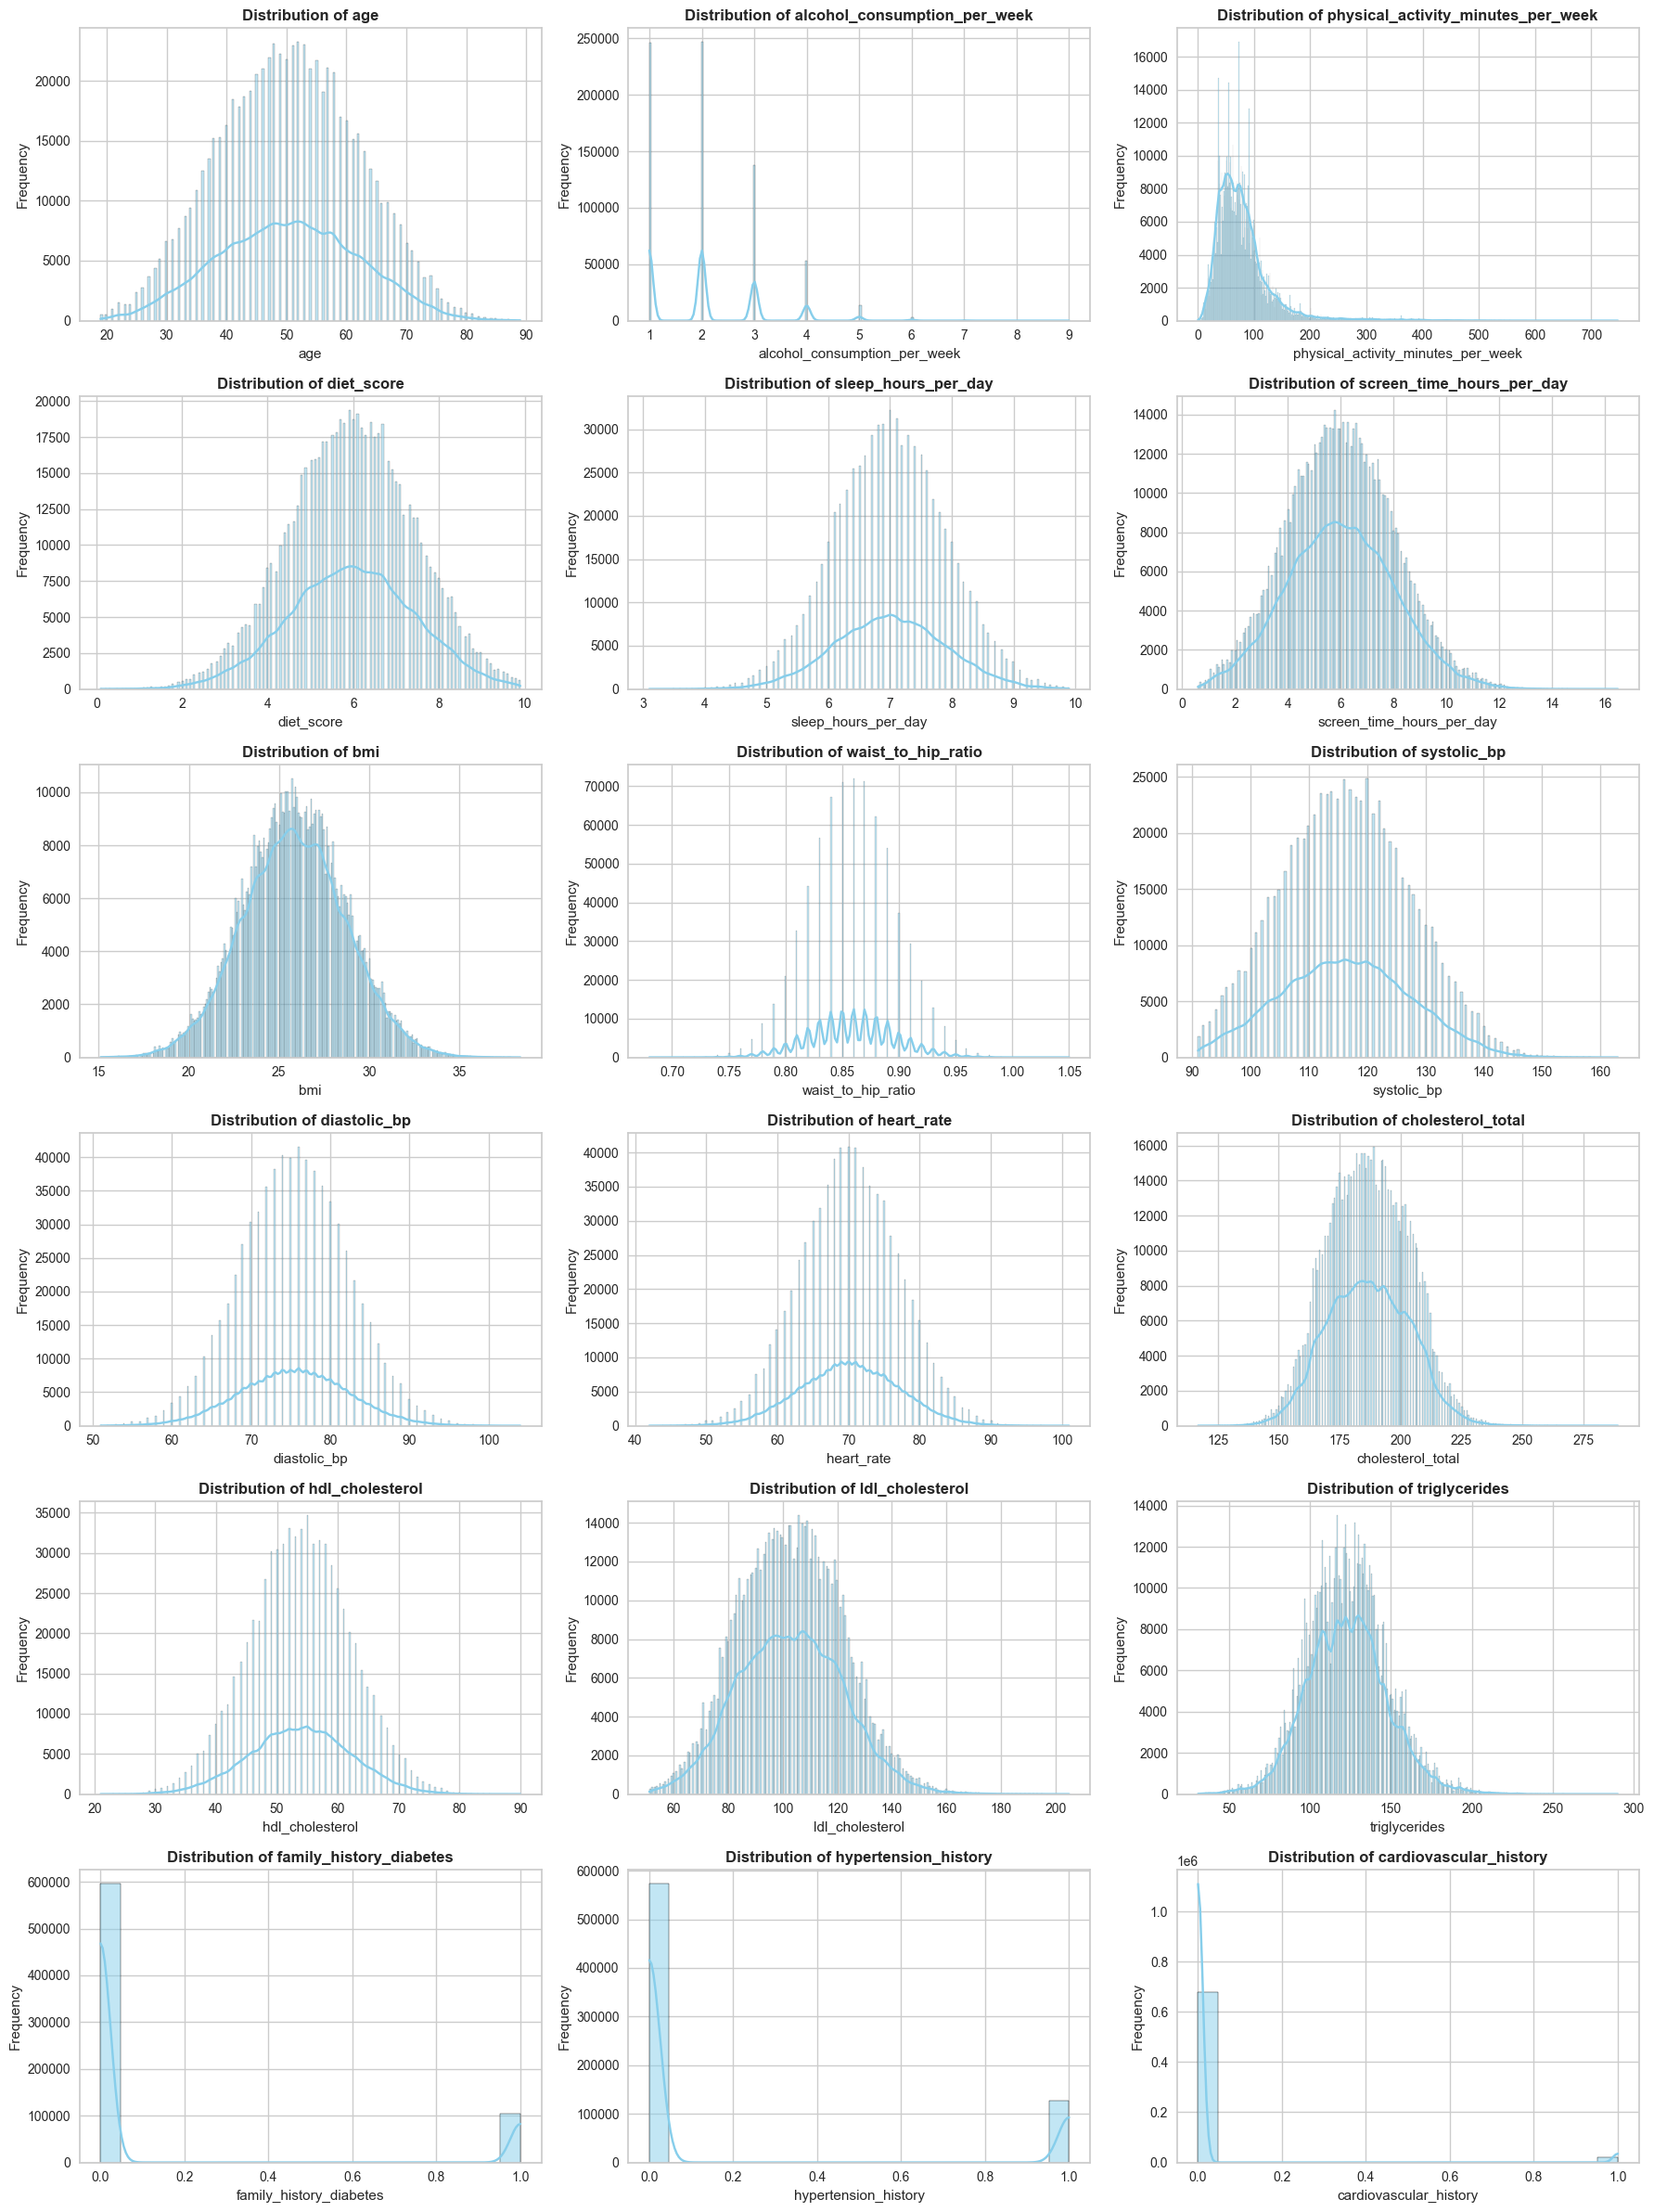

In [19]:
# Get numerical columns (excluding 'id')
numerical_cols = train.select_dtypes(include=['number']).drop(columns=['id', 'diagnosed_diabetes'], errors='ignore').columns

# Calculate number of plots needed
n_cols = len(numerical_cols)
n_rows = (n_cols + 2) // 3  # 3 columns per row

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Plot distribution for each numerical column
for idx, col in enumerate(numerical_cols):
    sns.histplot(train[col], kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Hide extra subplots if any
for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

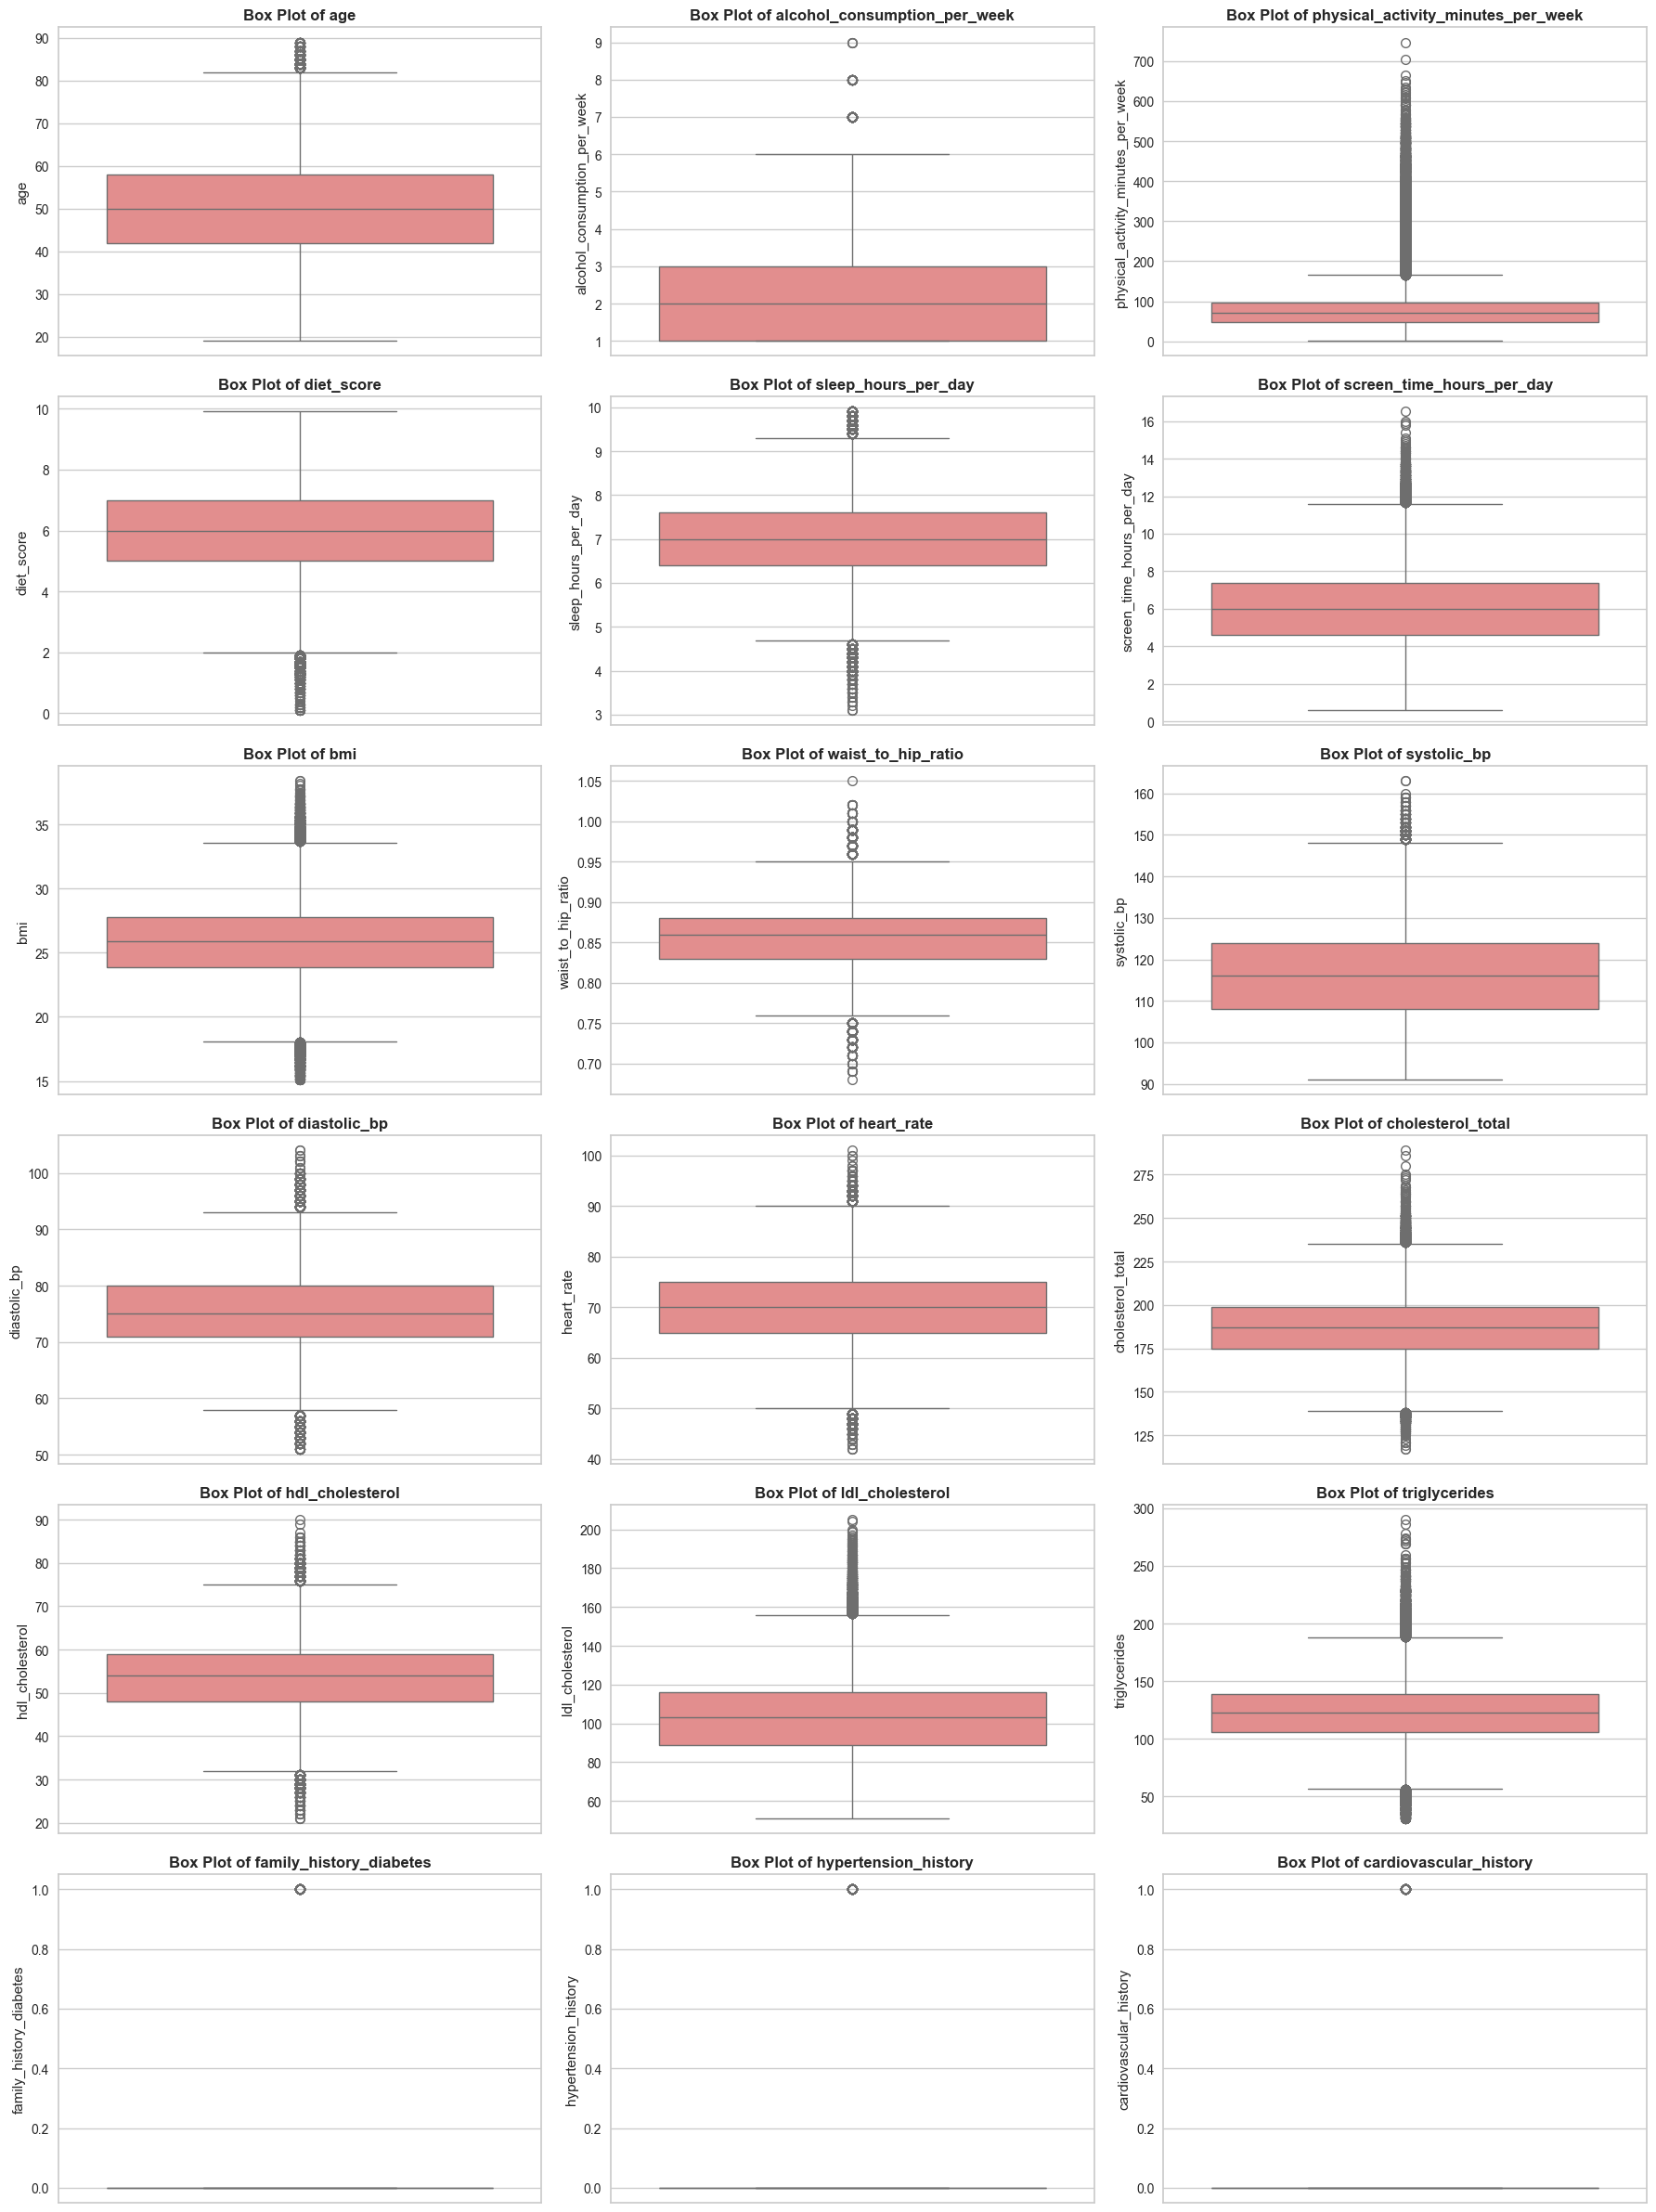

In [20]:
# Box plots for all numerical features
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.boxplot(y=train[col], ax=axes[idx], color='lightcoral')
    axes[idx].set_title(f'Box Plot of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)

for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

#### Distribution of the target feature: diagnosed_diabetes

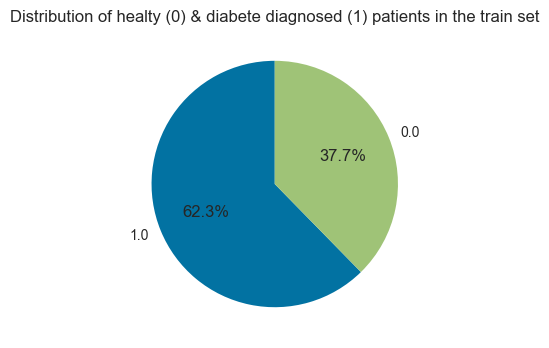

In [21]:
value_counts = train.diagnosed_diabetes.value_counts()

plt.figure(figsize=(4, 4))
value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of healty (0) & diabete diagnosed (1) patients in the train set')
plt.ylabel('')
plt.show()

# 0 - Features engineering

## Drop
- ethnicity
- gender
- employment_status
## Feature Encoding:
### income_level
- High -> 100
- Upper-Middle -> 75
- Middle 50
- Lower-Middle -> 25
- Low -> 0

### education_level
- No formal -> 0,
- Highschool -> 33,
- Graduate -> 66,
- Postgraduate -> 100

### smoking_status
- Current -> 0
- Former -> 50
- Never -> 100

### employment_status
- Student -> 100
- Unemployed -> 50
- Employed -> 50
- Retired -> 0

In [22]:
train.income_level.unique()

array(['Lower-Middle', 'Upper-Middle', 'Low', 'Middle', 'High'],
      dtype=object)

In [23]:
train.education_level.unique()

array(['Highschool', 'Graduate', 'Postgraduate', 'No formal'],
      dtype=object)

In [24]:
train.smoking_status.unique()

array(['Current', 'Never', 'Former'], dtype=object)

In [25]:
def clean_dataframe(df):
    df = df.copy()

    # Drop ethnicity
    df.drop(columns=['ethnicity'], inplace=True)
    df.drop(columns=['gender'], inplace=True)
    df.drop(columns=['employment_status'], inplace=True)

    # Remove rare gender
    #df = df[df["gender"] != "Other"].reset_index(drop=True)

    # Ordinal / risk encodings
    df['income_level'] = df['income_level'].replace({
        'Low': 0,
        'Middle': 50,
        'Lower-Middle': 25,
        'Upper-Middle': 75,
        'High': 100
    })

    df['education_level'] = df['education_level'].replace({
        'No formal': 0,
        'Highschool': 33,
        'Graduate': 66,
        'Postgraduate': 100
    })

    df['smoking_status'] = df['smoking_status'].replace({
        'Never': 100,
        'Former': 50,
        'Current': 0
    })

    #df['employment_status'] = df['employment_status'].replace({
    #    'Student': 0,
    #    'Unemployed': 0,
    #    'Employed': 1,
    #    'Retired': 1
    #})

    return df


# Apply to both sets
train = clean_dataframe(train)
test = clean_dataframe(test)
    
print("Train unique values:", train['income_level'].unique())
print("Test unique values:", test['income_level'].unique())
print("Train unique values:", train['education_level'].unique())
print("Test unique values:", test['education_level'].unique())
print("Train unique values:", train['smoking_status'].unique())
print("Test unique values:", test['smoking_status'].unique())



Train unique values: [ 25  75   0  50 100]
Test unique values: [ 50   0  25  75 100]
Train unique values: [ 33  66 100   0]
Test unique values: [ 33  66 100   0]
Train unique values: [  0 100  50]
Test unique values: [ 50 100   0]


In [26]:
# Drop target ONLY
df_train = train.drop(columns=['diagnosed_diabetes'])
df_test = test.copy()
df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

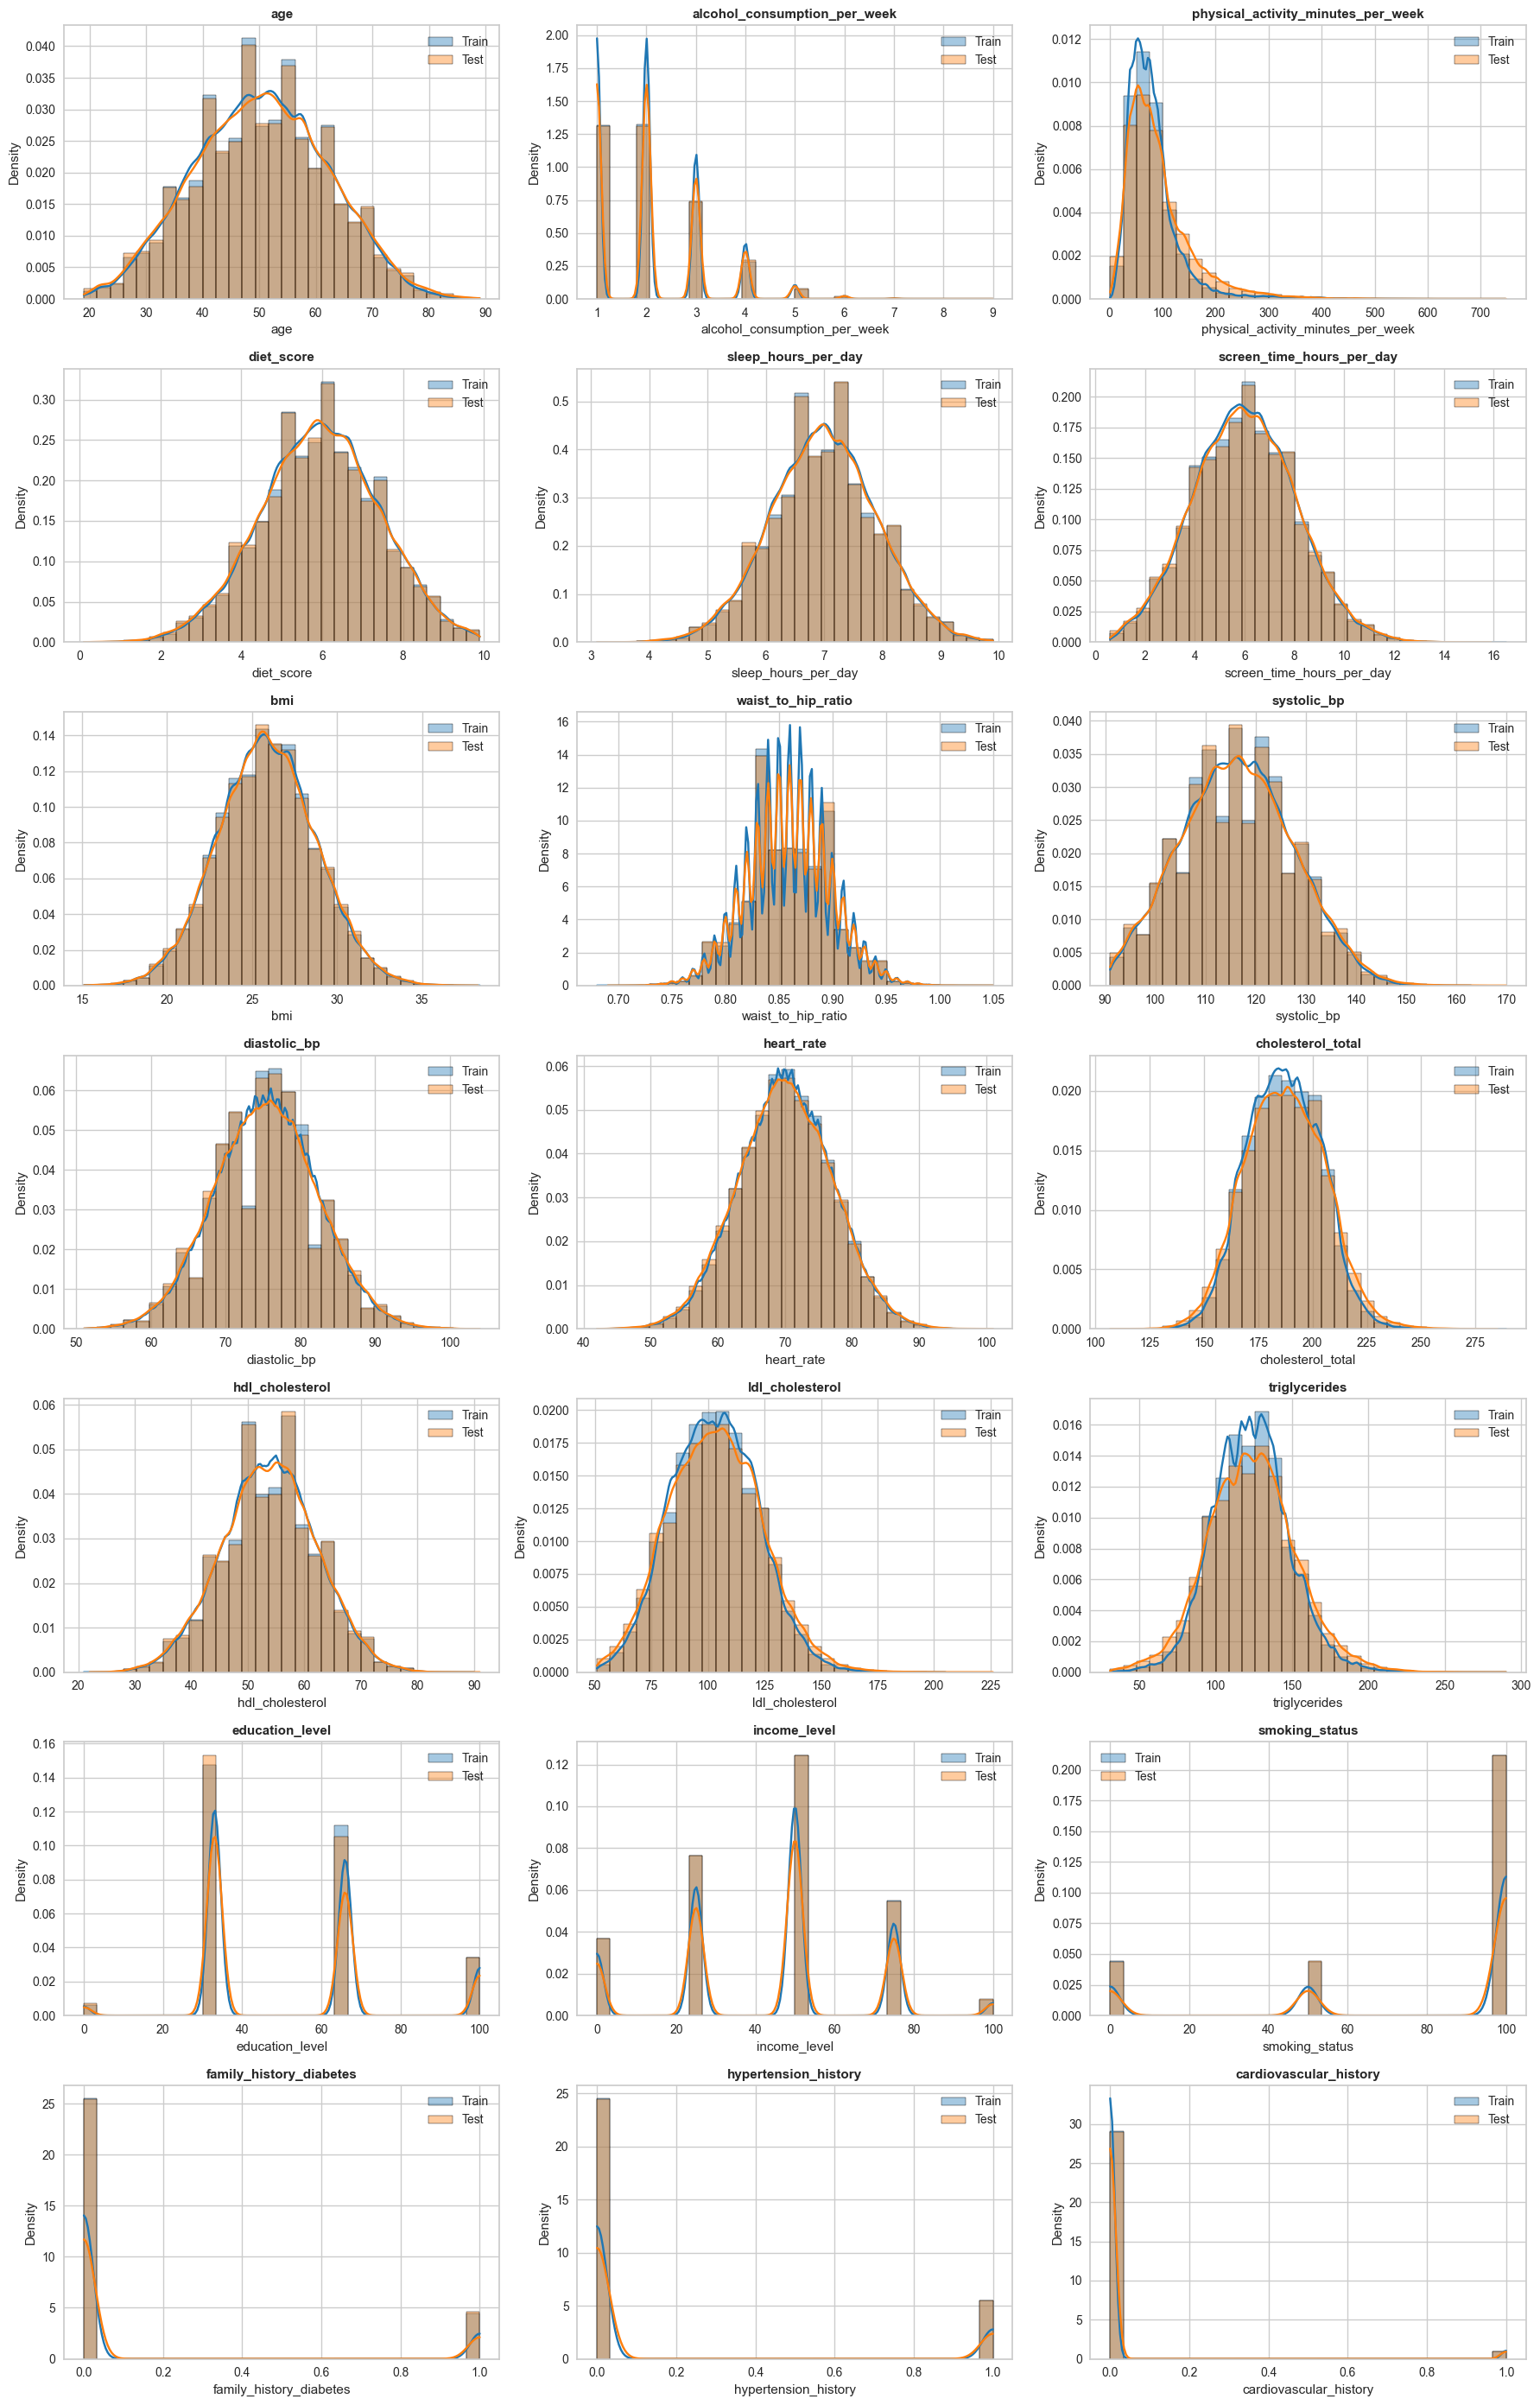

In [27]:
# Numerical columns (exclude target & id if present)
cols = [
    col for col in df_train.select_dtypes(include=['number']).columns
    if col not in ['diagnosed_diabetes', 'id']
]

n_cols = len(cols)
n_rows = (n_cols + 2) // 3  # 3 plots per row

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(cols):
    
    # Determine common bins
    combined = pd.concat([df_train[col], df_test[col]])
    bins = np.histogram_bin_edges(combined.dropna(), bins=30)

    # Train distribution
    sns.histplot(
        df_train[col],
        bins=bins,
        stat="density",
        kde=True,
        color="tab:blue",
        alpha=0.4,
        label="Train",
        ax=axes[idx]
    )

    # Test distribution
    sns.histplot(
        df_test[col],
        bins=bins,
        stat="density",
        kde=True,
        color="tab:orange",
        alpha=0.4,
        label="Test",
        ax=axes[idx]
    )

    axes[idx].set_title(f"{col}", fontsize=11, fontweight="bold")
    axes[idx].legend()

# Hide unused subplots
for idx in range(n_cols, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


# 1- Explore Tree-based models / Imbalance strategies

### Tree-based models: lightgbm / catboost / xgboost

### Imbalance startegies: No sampling / BorderlineSMOTE / RandomUnderSampler

In [29]:
overall_start = time.time()

# =============================================================================
# STEP 1: Prepare Data
# =============================================================================
print(f"\n[{datetime.now().strftime('%H:%M:%S')}] STEP 1: Preparing Data")
print("-" * 80)

X = df_train.copy()
y = train["diagnosed_diabetes"]

print(f"Dataset: {X.shape[0]:,} rows × {X.shape[1]} features")
class_dist = dict(y.value_counts())
print(f"Class distribution: {class_dist}")
print(f"Imbalance ratio: {class_dist[1]/class_dist[0]:.3f} (minority/majority)")

# =============================================================================
# STEP 2: Split Data (Stratified)
# =============================================================================
print(f"\n[{datetime.now().strftime('%H:%M:%S')}] STEP 2: Splitting Data")
print("-" * 80)

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.1, stratify=y, 
)

print(f"Training: {X_train.shape[0]:,} samples")
print(f"Validation: {X_validation.shape[0]:,} samples")
print(f"Training class dist: {dict(y_train.value_counts())}")

# =============================================================================
# STEP 3: Define Configuration
# =============================================================================
print(f"\n[{datetime.now().strftime('%H:%M:%S')}] STEP 3: Configuration")
print("-" * 80)

# Sampling strategies
sampling_strategies = {
    "None": None,
    #"SMOTE": SMOTE(),
    "BorderlineSMOTE": BorderlineSMOTE(),
    "ADASYN": ADASYN(),
    "RandomUnderSampler": RandomUnderSampler(),
    #"SMOTETomek": SMOTETomek(),
    "SMOTEENN": SMOTEENN(),
}

# Fast gradient boosting models only
models_to_test = [
    "lightgbm",
    "xgboost", 
    "catboost",
]

print(f"Models: {', '.join(models_to_test)}")
print(f"Sampling strategies: {len(sampling_strategies)}")
print("\n⚠️  Note: Class weights only tested with 'None' sampling (no double-correction)")

# Calculate expected combinations
# For "None" sampling: test with and without class weights (2 per model)
# For other sampling: only test without class weights (1 per model)
expected_combos = len(models_to_test) * 2 + (len(sampling_strategies) - 1) * len(models_to_test)
print(f"Expected combinations: {expected_combos}")

# Storage
all_results = []
best_models = {}

best_overall_auc = 0
best_overall_config = None

# =============================================================================
# STEP 4: Loop Over Sampling + Models + Class Weights (Smart Logic)
# =============================================================================
for strategy_name, sampler in sampling_strategies.items():
    
    print(f"\n{'='*80}")
    print(f"SAMPLING STRATEGY: {strategy_name}")
    print("=" * 80)
    
    strategy_start = time.time()
    
    # Apply sampling if specified
    if sampler is not None:
        try:
            X_res, y_res = sampler.fit_resample(X_train, y_train)
            print(f"Resampled distribution: {dict(pd.Series(y_res).value_counts())}")
        except Exception as e:
            print(f"⚠️  Sampling failed: {e}")
            continue
    else:
        X_res, y_res = X_train, y_train
        print(f"Original distribution: {dict(y_train.value_counts())}")
    
    # Prepare data for PyCaret
    train_res = pd.DataFrame(X_res, columns=X_train.columns)
    train_res["diagnosed_diabetes"] = y_res
    
    # CRITICAL LOGIC: Only test class weights when NO resampling is used
    if strategy_name == "None":
        class_weight_options = {
            "None": None,
            "balanced": "balanced",
        }
        print("\n  📊 Testing both unweighted and class-weighted models")
    else:
        class_weight_options = {
            "None": None,
        }
        print("\n  📊 Resampling applied - skipping class weights (avoid double-correction)")
    
    # Test each class weight option
    for weight_name, class_weight_val in class_weight_options.items():
        
        print(f"\n  {'─'*76}")
        print(f"  CLASS WEIGHT: {weight_name}")
        print(f"  {'─'*76}")
        
        # Setup PyCaret - optimize for AUC (same as sklearn ROC-AUC)
        clf = setup(
            data=train_res,
            target="diagnosed_diabetes",
            fold=5,
            n_jobs=-1,
            verbose=False,
            html=False,
            system_log=False  # Reduce logging
        )
        
        for model_name in models_to_test:
            model_start = time.time()
            
            print(f"\n    [{datetime.now().strftime('%H:%M:%S')}] Model: {model_name}")
            
            try:
                # Create base model with class_weight if applicable
                if weight_name == "balanced":
                    if model_name == "lightgbm":
                        base_model = create_model(model_name, class_weight='balanced', verbose=False)
                    elif model_name == "xgboost":
                        # XGBoost uses scale_pos_weight
                        scale_pos_weight = class_dist[0] / class_dist[1]
                        base_model = create_model(model_name, scale_pos_weight=scale_pos_weight, verbose=False)
                    elif model_name == "catboost":
                        # CatBoost with thread control to avoid file locking
                        base_model = create_model(
                            model_name, 
                            auto_class_weights='Balanced',
                            thread_count=1,  # Avoid file locking issues
                            verbose=False
                        )
                    else:
                        base_model = create_model(model_name, verbose=False)
                else:
                    # No class weights
                    if model_name == "catboost":
                        # CatBoost with thread control to avoid file locking
                        base_model = create_model(
                            model_name,
                            thread_count=1,  # Avoid file locking issues
                            verbose=False
                        )
                    else:
                        base_model = create_model(model_name, verbose=False)
                
                # Tune model optimizing for AUC
                tuned_model = tune_model(
                    base_model, 
                    optimize="AUC",
                    n_iter=10,
                    verbose=False
                )
                
                # Finalize model (train on full resampled data)
                final_model = finalize_model(tuned_model)
                
                # Get CV results
                results = pull()
                cv_auc = results.loc["Mean", "AUC"]
                
                # Calculate VALIDATION AUC (TRUE sklearn ROC-AUC)
                y_pred_proba = final_model.predict_proba(X_validation)[:, 1]
                validation_auc = roc_auc_score(y_validation, y_pred_proba)
                
                # Get parameters
                params = tuned_model.get_params() if hasattr(tuned_model, 'get_params') else {}
                
                print(f"      CV AUC       : {cv_auc:.4f}")
                print(f"      Val AUC      : {validation_auc:.4f}")
                print(f"      Time         : {time.time()-model_start:.1f}s")
                
                # Store results
                result_entry = {
                    "Sampling": strategy_name,
                    "Class_Weight": weight_name,
                    "Model": model_name,
                    "CV_AUC": cv_auc,
                    "Validation_AUC": validation_auc,
                    "Parameters": str(params)[:100]
                }
                all_results.append(result_entry)
                
                # Store model with probabilities for ensemble
                model_key = (strategy_name, weight_name, model_name)
                best_models[model_key] = {
                    'model': final_model,
                    'val_proba': y_pred_proba,
                    'val_auc': validation_auc
                }
                
                # Track best overall
                if validation_auc > best_overall_auc:
                    best_overall_auc = validation_auc
                    best_overall_config = {
                        "sampling": strategy_name,
                        "class_weight": weight_name,
                        "model": model_name,
                        "cv_auc": cv_auc,
                        "validation_auc": validation_auc,
                        "params": params,
                        "trained_model": final_model
                    }
                    print(f"      🎯 NEW BEST! Val AUC: {validation_auc:.4f}")
                
            except Exception as e:
                print(f"      ❌ Failed: {str(e)[:150]}")
                continue
    
    print(f"\n  Strategy total time: {time.time()-strategy_start:.1f}s")

# =============================================================================
# STEP 5: Results Summary
# =============================================================================
print("\n" + "=" * 80)
print("RESULTS SUMMARY (Sorted by Validation AUC)")
print("=" * 80)

results_df = (
    pd.DataFrame(all_results)
    .sort_values(by="Validation_AUC", ascending=False)
    .reset_index(drop=True)
)

print(results_df[["Sampling", "Class_Weight", "Model", "CV_AUC", "Validation_AUC"]].head(15).to_string(index=True))

# =============================================================================
# STEP 6: Best Model Analysis
# =============================================================================
print("\n" + "=" * 80)
print("🏆 BEST SINGLE MODEL")
print("=" * 80)
print(f"Sampling Strategy    : {best_overall_config['sampling']}")
print(f"Class Weight         : {best_overall_config['class_weight']}")
print(f"Model                : {best_overall_config['model']}")
print(f"CV AUC               : {best_overall_config['cv_auc']:.4f}")
print(f"Validation AUC       : {best_overall_config['validation_auc']:.4f}")
print("=" * 80)

# Detailed validation metrics
best_model = best_overall_config['trained_model']
y_pred = best_model.predict(X_validation)
y_pred_proba = best_model.predict_proba(X_validation)[:, 1]

print("\nValidation Prediction Statistics:")
print(pd.Series(y_pred_proba).describe())
print(f"Unique probabilities: {len(np.unique(y_pred_proba))}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_pred))
print("\nClassification Report:")
print(classification_report(y_validation, y_pred, target_names=['Healthy', 'Diabetes']))


[22:48:02] STEP 1: Preparing Data
--------------------------------------------------------------------------------
Dataset: 700,000 rows × 21 features
Class distribution: {1.0: 436307, 0.0: 263693}
Imbalance ratio: 1.655 (minority/majority)

[22:48:02] STEP 2: Splitting Data
--------------------------------------------------------------------------------
Training: 630,000 samples
Validation: 70,000 samples
Training class dist: {1.0: 392676, 0.0: 237324}

[22:48:03] STEP 3: Configuration
--------------------------------------------------------------------------------
Models: lightgbm, xgboost, catboost
Sampling strategies: 5

⚠️  Note: Class weights only tested with 'None' sampling (no double-correction)
Expected combinations: 18

SAMPLING STRATEGY: None
Original distribution: {1.0: 392676, 0.0: 237324}

  📊 Testing both unweighted and class-weighted models

  ────────────────────────────────────────────────────────────────────────────
  CLASS WEIGHT: None
  ───────────────────────────

In [32]:

# =============================================================================
# STEP 7: Ensemble Creation (Top N Models + Meta-Learning)
# =============================================================================
print("\n" + "=" * 80)
print("🔗 ENSEMBLE CREATION WITH META-LEARNING")
print("=" * 80)

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
from scipy.stats import rankdata

# Select top N models based on validation AUC
TOP_N = min(7, len(results_df))  # Increased from 5 to 7 for more diversity
top_configs = results_df.head(TOP_N)

print(f"\nBuilding ensemble from top {TOP_N} models:")
for idx, row in top_configs.iterrows():
    print(f"  {idx+1}. {row['Model']:12s} | {row['Sampling']:18s} | {row['Class_Weight']:10s} | AUC: {row['Validation_AUC']:.4f}")

# Collect predictions from top models
ensemble_predictions = []
ensemble_weights = []
model_names = []

for idx, row in top_configs.iterrows():
    key = (row['Sampling'], row['Class_Weight'], row['Model'])
    if key in best_models:
        model_info = best_models[key]
        ensemble_predictions.append(model_info['val_proba'])
        ensemble_weights.append(model_info['val_auc'])
        model_names.append(f"{row['Model']}_{row['Sampling'][:4]}")

# Convert to array
ensemble_predictions = np.array(ensemble_predictions)
ensemble_weights = np.array(ensemble_weights)

# Create feature matrix for meta-learning (each column is a model's predictions)
X_meta = ensemble_predictions.T  # Shape: (n_samples, n_models)

print(f"\nMeta-feature matrix: {X_meta.shape} (samples × models)")

# =============================================================================
# Method 1: Simple Average
# =============================================================================
ensemble_avg = np.mean(ensemble_predictions, axis=0)
ensemble_avg_auc = roc_auc_score(y_validation, ensemble_avg)

# =============================================================================
# Method 2: Weighted Average (by validation AUC)
# =============================================================================
ensemble_weights_norm = ensemble_weights / ensemble_weights.sum()
ensemble_weighted = np.average(ensemble_predictions, axis=0, weights=ensemble_weights_norm)
ensemble_weighted_auc = roc_auc_score(y_validation, ensemble_weighted)

# =============================================================================
# Method 3: Rank Average
# =============================================================================
ensemble_ranks = np.array([rankdata(pred) for pred in ensemble_predictions])
ensemble_rank_avg = np.mean(ensemble_ranks, axis=0)
ensemble_rank_auc = roc_auc_score(y_validation, ensemble_rank_avg)

# =============================================================================
# Method 4: Ridge Regression Meta-Learner (Linear Stacking)
# =============================================================================
ridge_meta = Ridge(alpha=1.0)
ridge_meta.fit(X_meta, y_validation)
ensemble_ridge = ridge_meta.predict(X_meta)
# Clip to [0, 1] for valid probabilities
ensemble_ridge = np.clip(ensemble_ridge, 0, 1)
ensemble_ridge_auc = roc_auc_score(y_validation, ensemble_ridge)
ridge_weights = ridge_meta.coef_

# =============================================================================
# Method 5: Lasso Regression Meta-Learner (Sparse Stacking)
# =============================================================================
lasso_meta = Lasso(alpha=0.001, max_iter=10000)
lasso_meta.fit(X_meta, y_validation)
ensemble_lasso = lasso_meta.predict(X_meta)
ensemble_lasso = np.clip(ensemble_lasso, 0, 1)
ensemble_lasso_auc = roc_auc_score(y_validation, ensemble_lasso)
lasso_weights = lasso_meta.coef_

# =============================================================================
# Method 6: Elastic Net Meta-Learner (Balanced Regularization)
# =============================================================================
elastic_meta = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
elastic_meta.fit(X_meta, y_validation)
ensemble_elastic = elastic_meta.predict(X_meta)
ensemble_elastic = np.clip(ensemble_elastic, 0, 1)
ensemble_elastic_auc = roc_auc_score(y_validation, ensemble_elastic)
elastic_weights = elastic_meta.coef_

# =============================================================================
# Method 7: Logistic Regression Meta-Learner (Probability Calibrated)
# =============================================================================
logistic_meta = LogisticRegression(max_iter=1000, C=1.0)
logistic_meta.fit(X_meta, y_validation)
ensemble_logistic = logistic_meta.predict_proba(X_meta)[:, 1]
ensemble_logistic_auc = roc_auc_score(y_validation, ensemble_logistic)
logistic_weights = logistic_meta.coef_[0]

# =============================================================================
# Method 8: Constrained Optimization (Minimize negative AUC)
# =============================================================================
def negative_auc(weights):
    """Objective function: negative AUC to minimize"""
    weights = np.abs(weights)  # Ensure positive
    weights = weights / weights.sum()  # Normalize
    ensemble_pred = np.average(ensemble_predictions, axis=0, weights=weights)
    return -roc_auc_score(y_validation, ensemble_pred)

# Initial guess: uniform weights
initial_weights = np.ones(len(ensemble_predictions)) / len(ensemble_predictions)

# Constraints: weights sum to 1 and are non-negative
constraints = {'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1}
bounds = [(0, 1) for _ in range(len(ensemble_predictions))]

result = minimize(
    negative_auc,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000}
)

optimal_weights = result.x
ensemble_optimal = np.average(ensemble_predictions, axis=0, weights=optimal_weights)
ensemble_optimal_auc = roc_auc_score(y_validation, ensemble_optimal)

# =============================================================================
# Results Summary
# =============================================================================
print("\n" + "─" * 80)
print("ENSEMBLE PERFORMANCE COMPARISON")
print("─" * 80)
print(f"  1. Simple Average          : {ensemble_avg_auc:.4f}")
print(f"  2. Weighted Average (AUC)  : {ensemble_weighted_auc:.4f}")
print(f"  3. Rank Average            : {ensemble_rank_auc:.4f}")
print(f"  4. Ridge Meta-Learner      : {ensemble_ridge_auc:.4f}")
print(f"  5. Lasso Meta-Learner      : {ensemble_lasso_auc:.4f}")
print(f"  6. Elastic Net Meta-Learner: {ensemble_elastic_auc:.4f}")
print(f"  7. Logistic Meta-Learner   : {ensemble_logistic_auc:.4f}")
print(f"  8. Optimized Weights       : {ensemble_optimal_auc:.4f}")
print(f"\n  Best Single Model          : {best_overall_auc:.4f}")
print("─" * 80)

# Select best ensemble method
ensemble_methods = {
    'simple': (ensemble_avg, ensemble_avg_auc, None),
    'weighted': (ensemble_weighted, ensemble_weighted_auc, ensemble_weights_norm),
    'rank': (ensemble_rank_avg, ensemble_rank_auc, None),
    'ridge': (ensemble_ridge, ensemble_ridge_auc, ridge_weights),
    'lasso': (ensemble_lasso, ensemble_lasso_auc, lasso_weights),
    'elastic': (ensemble_elastic, ensemble_elastic_auc, elastic_weights),
    'logistic': (ensemble_logistic, ensemble_logistic_auc, logistic_weights),
    'optimal': (ensemble_optimal, ensemble_optimal_auc, optimal_weights)
}

best_ensemble_method = max(ensemble_methods.items(), key=lambda x: x[1][1])
best_ensemble_name, (best_ensemble_pred, best_ensemble_auc, best_ensemble_weights) = best_ensemble_method

print(f"\n✅ Best Ensemble Method: {best_ensemble_name.upper()} (AUC: {best_ensemble_auc:.4f})")

# Show weights for interpretability
if best_ensemble_weights is not None:
    print("\n📊 Model Weights in Best Ensemble:")
    for name, weight in zip(model_names, best_ensemble_weights):
        print(f"  {name:20s}: {weight:+.4f} ({weight/best_ensemble_weights.sum()*100:5.1f}%)")

# Store meta-learners for test predictions
meta_learners = {
    'ridge': ridge_meta,
    'lasso': lasso_meta,
    'elastic': elastic_meta,
    'logistic': logistic_meta,
    'optimal': optimal_weights
}

# Decide: Ensemble or Single Model?
use_ensemble = best_ensemble_auc > best_overall_auc
final_method = best_ensemble_name if use_ensemble else "single_model"
final_auc = best_ensemble_auc if use_ensemble else best_overall_auc

print("\n" + "=" * 80)
print(f"🎯 FINAL SELECTION: {'ENSEMBLE' if use_ensemble else 'SINGLE MODEL'}")
print(f"   Method: {final_method.upper()}")
print(f"   Validation AUC: {final_auc:.4f}")
improvement = (final_auc - best_overall_auc) * 100
print(f"   Improvement: {improvement:+.2f}% over best single model")
if improvement > 0:
    print(f"   📈 Ensemble wins by {improvement:.2f}%!")
else:
    print(f"   Single model is still best (ensemble overfits by {abs(improvement):.2f}%)")
print("=" * 80)


🔗 ENSEMBLE CREATION WITH META-LEARNING

Building ensemble from top 7 models:
  1. lightgbm     | ADASYN             | None       | AUC: 0.7288
  2. catboost     | None               | None       | AUC: 0.7288
  3. catboost     | None               | balanced   | AUC: 0.7287
  4. catboost     | BorderlineSMOTE    | None       | AUC: 0.7284
  5. catboost     | ADASYN             | None       | AUC: 0.7282
  6. catboost     | RandomUnderSampler | None       | AUC: 0.7275
  7. lightgbm     | None               | balanced   | AUC: 0.7272

Meta-feature matrix: (70000, 7) (samples × models)

────────────────────────────────────────────────────────────────────────────────
ENSEMBLE PERFORMANCE COMPARISON
────────────────────────────────────────────────────────────────────────────────
  1. Simple Average          : 0.7299
  2. Weighted Average (AUC)  : 0.7299
  3. Rank Average            : 0.7299
  4. Ridge Meta-Learner      : 0.7301
  5. Lasso Meta-Learner      : 0.7301
  6. Elastic Net Meta-L

In [33]:
# =============================================================================
# STEP 8: Prepare Test Set & Generate Predictions
# =============================================================================
print("\n" + "=" * 80)
print("📊 PREPARING TEST SET")
print("=" * 80)

# Ensure same column order as training
X_test = df_test[X_train.columns]

print(f"Test shape     : {X_test.shape}")
print(f"Train shape    : {X_train.shape}")
print(f"Columns match  : {list(X_test.columns) == list(X_train.columns)}")

# Generate predictions
print("\n" + "─" * 80)
print("Generating Test Predictions...")
print("─" * 80)

if use_ensemble:
    # Ensemble predictions - collect from top models
    test_predictions = []
    for idx, row in top_configs.iterrows():
        key = (row['Sampling'], row['Class_Weight'], row['Model'])
        if key in best_models:
            model = best_models[key]['model']
            test_pred = model.predict_proba(X_test)[:, 1]
            test_predictions.append(test_pred)
            print(f"  ✓ {row['Model']:12s} | {row['Sampling']:18s}")
    
    test_predictions = np.array(test_predictions)
    X_test_meta = test_predictions.T  # Shape: (n_samples, n_models)
    
    # Apply best ensemble method
    if best_ensemble_name == 'simple':
        test_proba = np.mean(test_predictions, axis=0)
        
    elif best_ensemble_name == 'weighted':
        test_proba = np.average(test_predictions, axis=0, weights=ensemble_weights_norm)
        
    elif best_ensemble_name == 'rank':
        test_ranks = np.array([rankdata(pred) for pred in test_predictions])
        test_proba = np.mean(test_ranks, axis=0)
        # Normalize to [0, 1]
        test_proba = (test_proba - test_proba.min()) / (test_proba.max() - test_proba.min())
        
    elif best_ensemble_name == 'ridge':
        test_proba = meta_learners['ridge'].predict(X_test_meta)
        test_proba = np.clip(test_proba, 0, 1)
        
    elif best_ensemble_name == 'lasso':
        test_proba = meta_learners['lasso'].predict(X_test_meta)
        test_proba = np.clip(test_proba, 0, 1)
        
    elif best_ensemble_name == 'elastic':
        test_proba = meta_learners['elastic'].predict(X_test_meta)
        test_proba = np.clip(test_proba, 0, 1)
        
    elif best_ensemble_name == 'logistic':
        test_proba = meta_learners['logistic'].predict_proba(X_test_meta)[:, 1]
        
    elif best_ensemble_name == 'optimal':
        test_proba = np.average(test_predictions, axis=0, weights=meta_learners['optimal'])
    
    print(f"\n✓ Ensemble ({best_ensemble_name.upper()}) predictions generated")
    print(f"  Method: {'Meta-learning' if best_ensemble_name in ['ridge', 'lasso', 'elastic', 'logistic'] else 'Weighted averaging'}")
    
else:
    # Single model predictions
    test_proba = best_model.predict_proba(X_test)[:, 1]
    print(f"✓ Single model predictions generated")
    print(f"  Model: {best_overall_config['model']}")
    print(f"  Sampling: {best_overall_config['sampling']}")

print("\nTest Probability Statistics:")
print(pd.Series(test_proba).describe())


📊 PREPARING TEST SET
Test shape     : (300000, 21)
Train shape    : (630000, 21)
Columns match  : True

────────────────────────────────────────────────────────────────────────────────
Generating Test Predictions...
────────────────────────────────────────────────────────────────────────────────
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
  ✓ lightgbm     | ADASYN            
  ✓ catboost     | None              
  ✓ catboost     | None              
  ✓ catboost     | BorderlineSMOTE   
  ✓ catboost     | ADASYN            
  ✓ catboost     | RandomUnderSampler
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[

In [34]:

# =============================================================================
# STEP 9: Create Kaggle Submission
# =============================================================================
print("\n" + "=" * 80)
print("💾 CREATING KAGGLE SUBMISSION")
print("=" * 80)

submission = pd.DataFrame({
    'id': df_test.index,
    'diagnosed_diabetes': test_proba
})

print("\nSubmission DataFrame (first 10 rows):")
print(submission.head(10))

print(f"\nSubmission shape: {submission.shape}")
print(f"Columns: {list(submission.columns)}")

# Sanity checks
print("\n" + "─" * 80)
print("Sanity Checks:")
print(f"  ✓ No NaN values       : {submission['diagnosed_diabetes'].isna().sum() == 0}")
print(f"  ✓ All in [0,1] range  : {submission['diagnosed_diabetes'].between(0, 1).all()}")
print(f"  ✓ Correct shape       : {submission.shape == (len(df_test), 2)}")
print(f"  ✓ Unique predictions  : {submission['diagnosed_diabetes'].nunique()}")
print("─" * 80)

# Save submission
filename = r'C:\Users\DELL\Desktop\DataScience\Kaggle\DiabetesPredictionChallenge\submission_imbalance_best_model.csv'
submission.to_csv(filename, index=False)

print(f"\n✅ Submission saved to:")
print(f"   {filename}")
print(f"   Total rows: {len(submission):,}")

# =============================================================================
# STEP 10: Access Guide & Export
# =============================================================================
print("\n" + "=" * 80)
print("📊 ACCESSING RESULTS")
print("=" * 80)
print("\nKey Objects:")
print("  • results_df              : Full comparison DataFrame")
print("  • best_models             : Dict of all trained models")
print("  • best_overall_config     : Best single model configuration")
print("  • submission              : Final Kaggle submission DataFrame")
print("\nExamples:")
print("  # View top 10 configurations")
print("  results_df.head(10)")
print("\n  # Get specific model")
print("  best_models[('SMOTE', 'None', 'lightgbm')]['model']")
print("\n  # Export full results")
print("  results_df.to_csv('all_model_results.csv', index=False)")
print("\n  # Use best model directly")
print("  best_model = best_overall_config['trained_model']")
print("  my_predictions = best_model.predict_proba(my_data)[:, 1]")

# Export results summary
results_summary_file = r'C:\Users\DELL\Desktop\DataScience\Kaggle\DiabetesPredictionChallenge\model_comparison_results.csv'
results_df.to_csv(results_summary_file, index=False)
print(f"\n✅ Results exported to:")
print(f"   {results_summary_file}")

# =============================================================================
# FINAL SUMMARY
# =============================================================================
total_time = time.time() - overall_start
print(f"\n{'='*80}")
print("✅ PIPELINE COMPLETED")
print("=" * 80)
print(f"Total Runtime        : {total_time:.2f}s ({total_time/60:.2f} min)")
print(f"Configurations Tested: {len(all_results)}")
print(f"Best Single AUC      : {best_overall_auc:.4f}")
print(f"Final Submission AUC : {final_auc:.4f} ({'Ensemble' if use_ensemble else 'Single'})")
print(f"Timestamp            : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)


💾 CREATING KAGGLE SUBMISSION

Submission DataFrame (first 10 rows):
       id  diagnosed_diabetes
0  700000            0.487546
1  700001            0.662151
2  700002            0.766191
3  700003            0.400381
4  700004            0.939031
5  700005            0.666188
6  700006            0.750475
7  700007            0.946112
8  700008            0.573473
9  700009            0.857899

Submission shape: (300000, 2)
Columns: ['id', 'diagnosed_diabetes']

────────────────────────────────────────────────────────────────────────────────
Sanity Checks:
  ✓ No NaN values       : True
  ✓ All in [0,1] range  : True
  ✓ Correct shape       : True
  ✓ Unique predictions  : 299710
────────────────────────────────────────────────────────────────────────────────

✅ Submission saved to:
   C:\Users\DELL\Desktop\DataScience\Kaggle\DiabetesPredictionChallenge\submission_imbalance_best_model.csv
   Total rows: 300,000

📊 ACCESSING RESULTS

Key Objects:
  • results_df              : Full com

### Feature Importance

In [ ]:

results_df

NameError: name 'results_df' is not defined